In [1]:
import os
import collections
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data

from ptsemseg.utils import recursive_glob
from ptsemseg.metrics import runningScore
from ptsemseg.models import get_model
from ptsemseg.loss import *

In [2]:
mbatch_size = 4
mn_epoch = 2
mvisdom = False
march = 'segnet'
ml_rate = 0.1
mresume = None

In [59]:
class NYUD2Loader(data.Dataset):
    def __init__(self, root, split= "training", is_transform = False, img_size=(240,320), splitRate = 0.7):
        self.root = root + 'imgs/'
        self.n_classes = 40
        self.split = split
        self.splitRate = splitRate
        self.is_transform = is_transform
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array([122.5454, 104.7834, 100.0239])
        self.files_rgb = recursive_glob(rootdir=self.root + 'rgb/', suffix='.png')
        self.datasize = len(self.files_rgb)
        self.startIndex = 0 if(split=="training") else int(self.datasize*splitRate)
        
    def __len__(self):
        if(self.split == "training"):
            return int(self.datasize*self.splitRate)
        return int(self.datasize*(1-self.splitRate))+1
    def __getitem__(self, index):
        index = index + self.startIndex+1
        rgb_path = self.root + 'rgb/' + str(index) + '.png'
        lbl_path = self.root + 'label/' + str(index) + '.png'
        
        rgb = imageio.imread(rgb_path)
        rgb = np.array(rgb, dtype = np.uint8)
        lbl = imageio.imread(lbl_path)
        lbl = np.array(lbl, dtype = np.int32)
        
        if(self.transform):
            rgb, lbl = self.transform(rgb, lbl)
        return rgb, lbl
    
    def transform(self, img, lbl):
        img = img[:, :, ::-1]
        img = img.astype(np.float64)
        img -= self.mean
        img = resize(img, (self.img_size[0], self.img_size[1]), mode='reflect')
        # Resize scales images from 0 to 255, thus we need
        # to divide by 255.0
        img = img.astype(float) / 255.0
        # NHWC -> NCWH
        img = img.transpose(2, 0, 1)
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = resize(lbl, (self.img_size[0], self.img_size[1]), mode='reflect')
        lbl = lbl.astype(int)

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

In [53]:
data_path = "C:/Projects/getHHA/"
traindata_nyu = NYUD2Loader(data_path, split='training', is_transform = True)
trainloader_nyu = torch.utils.data.DataLoader(traindata_nyu, batch_size = mbatch_size, shuffle=True)

valdata_nyu = NYUD2Loader(data_path, split='validation', is_transform = True)
valloader_nyu = torch.utils.data.DataLoader(valdata_nyu, batch_size= mbatch_size, shuffle=True)

n_classes_nyu = traindata_nyu.n_classes
print(valdata_nyu.startIndex)

1014


In [54]:
class ADE20KLoader(data.Dataset):
    def __init__(self, root, split="training", is_transform=False, img_size=256, augmentations=None):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 150
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)

        for split in ["training", "validation",]:
            file_list = recursive_glob(rootdir=self.root + 'images/' + self.split + '/', suffix='.jpg')
            self.files[split] = file_list
    def __len__(self):
        return len(self.files[self.split])
    def __getitem__(self, index):
        img_path = self.files[self.split][index].rstrip()
        lbl_path = img_path[:-4] + '_seg.png'

        img = imageio.imread(img_path)
        img = np.array(img , dtype=np.uint8)

        lbl = imageio.imread(lbl_path)
        lbl = np.array(lbl, dtype=np.int32)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl
    
    def transform(self, img, lbl):
        if(len(img.shape)!=3):
            timg = np.zeros([img.shape[0], img.shape[1], 3])
            for i in range(3):
                timg[:,:,i] = np.copy(img)
            img = timg
        img = img[:, :, ::-1]
        img = img.astype(np.float64)
        img -= self.mean
        img = resize(img, (self.img_size[0], self.img_size[1]), mode='reflect')
        # Resize scales images from 0 to 255, thus we need
        # to divide by 255.0
        img = img.astype(float) / 255.0
        # NHWC -> NCWH
        img = img.transpose(2, 0, 1)

        lbl = self.encode_segmap(lbl)
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = resize(lbl, (self.img_size[0], self.img_size[1]), mode='reflect')
        lbl = lbl.astype(int)

#         assert(np.all(classes == np.unique(lbl)))

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl


    def encode_segmap(self, mask):
        # Refer : http://groups.csail.mit.edu/vision/datasets/ADE20K/code/loadAde20K.m
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]))
        label_mask = ( mask[:,:,0] / 10.0 ) * 256 + mask[:,:,1]
        return np.array(label_mask, dtype=np.uint8)

    def decode_segmap(self, temp, plot=True):
        # TODO:(@meetshah1995)
        # Verify that the color mapping is 1-to-1
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = 10 * (l%10)
            g[temp == l] = l
            b[temp == l] = 0

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = (r/255.0)
        rgb[:, :, 1] = (g/255.0)
        rgb[:, :, 2] = (b/255.0)
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

In [55]:
data_path = "C:/Projects/pytorch-semseg-master/data/ADE20K_2016_07_26/"
traindata = ADE20KLoader(data_path, split='training', is_transform = True)
trainloader = torch.utils.data.DataLoader(traindata, batch_size = mbatch_size, shuffle=True)

valdata = ADE20KLoader(data_path, split='validation', is_transform = True)
valloader = torch.utils.data.DataLoader(valdata, batch_size= mbatch_size, shuffle=True)

n_classes = traindata.n_classes

In [56]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    img = np.transpose(npimg, (1,2,0))
    img = img[:,:,::-1]
    plt.imshow(img)
    

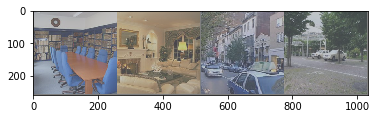

In [57]:
iterator = iter(trainloader)
images,labels = iterator.next()

imshow(torchvision.utils.make_grid(images))
plt.show()

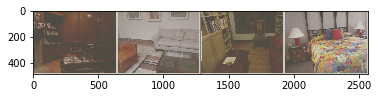

In [58]:
iterator_nyu = iter(trainloader_nyu)
images_nyu, labels_nyu = iterator_nyu.next()
imshow(torchvision.utils.make_grid(images_nyu))
plt.show()

In [7]:
# Setup visdom for visualization
if mvisdom:
    vis = visdom.Visdom()
    loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                       Y=torch.zeros((1)).cpu(),
                       opts=dict(xlabel='minibatches',
                                 ylabel='Loss',
                                 title='Training Loss',
                                 legend=['Loss']))

In [8]:
# Setup Metrics
running_metrics = runningScore(n_classes)

model = get_model(march, n_classes)
deviceAv = torch.cuda.device_count()
print (deviceAv)
model = nn.DataParallel(model, device_ids= range(deviceAv))
model.cuda()

1


DataParallel(
  (module): segnet(
    (down1): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU(inplace)
        )
      )
      (conv2): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU(inplace)
        )
      )
      (maxpool_with_argmax): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (down2): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU(inplace)
        )
      )
      (conv2): con

In [9]:
if hasattr(model.module, 'optimizer'):
    optimizer = model.module.optimizer
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=ml_rate, momentum=0.99, weight_decay=5e-4)

if hasattr(model.module, 'loss'):
    print('Using custom loss')
    loss_fn = model.module.loss
else:
    loss_fn = cross_entropy2d

In [10]:
if mresume is not None:
    if os.path.isfile(args.resume):
        print("Loading model and optimizer from checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(args.resume))

In [11]:
best_iou = -100.0
for epoch in range(mn_epoch):
    model.train()
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(input=outputs, target=labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print("Epoch [%d/%d] Loss: %.4f" % (epoch+1, mn_epoch, loss.data[0]))

    model.eval()
    for i_val, (images_val, labels_val) in enumerate(valloader):
        images_val = Variable(images_val.cuda(), volatile=True)
        labels_val = Variable(labels_val.cuda(), volatile=True)

        outputs = model(images_val)
        pred = outputs.data.max(1)[1].cpu().numpy()
        gt = labels_val.data.cpu().numpy()
        running_metrics.update(gt, pred)

    score, class_iou = running_metrics.get_scores()
    for k, v in score.items():
        print(k, v)
    running_metrics.reset()

    if score['Mean IoU : \t'] >= best_iou:
        best_iou = score['Mean IoU : \t']
        state = {'epoch': epoch+1,
                 'model_state': model.state_dict(),
                 'optimizer_state' : optimizer.state_dict(),}
        torch.save(state, "{}_{}_best_model.pkl".format(args.arch, args.dataset))

Epoch [1/2] Loss: 4.5843
Epoch [1/2] Loss: 3.7748
Epoch [1/2] Loss: 3.6732
Epoch [1/2] Loss: 4.3125
Epoch [1/2] Loss: 3.6403
Epoch [1/2] Loss: 3.9863
Epoch [1/2] Loss: 3.3975
Epoch [1/2] Loss: 3.8907
Epoch [1/2] Loss: 3.6304
Epoch [1/2] Loss: 3.4256
Epoch [1/2] Loss: 3.7917
Epoch [1/2] Loss: 3.4933
Epoch [1/2] Loss: 3.4901
Epoch [1/2] Loss: 3.7551
Epoch [1/2] Loss: 3.9519
Epoch [1/2] Loss: 3.3985
Epoch [1/2] Loss: 3.9516
Epoch [1/2] Loss: 3.1086
Epoch [1/2] Loss: 4.3240
Epoch [1/2] Loss: 3.6000
Epoch [1/2] Loss: 2.8898
Epoch [1/2] Loss: 3.7552
Epoch [1/2] Loss: 4.3136
Epoch [1/2] Loss: 3.6733
Epoch [1/2] Loss: 3.3434
Epoch [1/2] Loss: 2.7783
Epoch [1/2] Loss: 3.0883
Epoch [1/2] Loss: 3.1449
Epoch [1/2] Loss: 3.7149
Epoch [1/2] Loss: 3.6732
Epoch [1/2] Loss: 3.3428
Epoch [1/2] Loss: 3.7709
Epoch [1/2] Loss: 3.8899
Epoch [1/2] Loss: 3.8760
Epoch [1/2] Loss: 3.1905
Epoch [1/2] Loss: 2.5800
Epoch [1/2] Loss: 3.8853
Epoch [1/2] Loss: 3.3208
Epoch [1/2] Loss: 3.6500
Epoch [1/2] Loss: 4.0068


NameError: name 'tqdm' is not defined